In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree
import imageio
from datetime import datetime
from pytz import timezone
import pytz

In [3]:
def load_data(year):
    path = f"/nrel/nsrdb/v3/nsrdb_{year}.h5"
    return h5pyd.File(path, 'r')

def load_state_data(f, state):
    # Full resolution subset of California
    meta = pd.DataFrame(f['meta'][:])
    s = meta.loc[meta['state'] == state.encode('ASCII')] # Note .h5 saves strings as bit-strings
    return s

def plot_state_ghi(f, timestamp, state, file_name):
    time_index = pd.to_datetime(f['time_index'][...].astype(str))
    timestep = np.where(time_index == timestamp)[0][0]
    data = f['ghi'][timestep][state.index]  # full-resolution subset
    df = state[['longitude', 'latitude']].copy()
    df['ghi'] = data / f['ghi'].attrs['psm_scale_factor'] # Get the ghi of every (longitude, latitude) in California
    df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=utc_to_pst(str(time_index[timestep])))
    plt.savefig(file_name)
    # plt.show()
    
    
def plot_ghi(f, timestamp, coords, data):
    time_index = pd.to_datetime(f['time_index'][...].astype(str))
    timestep = np.where(time_index == timestamp)[0][0]
    # coords = f['coordinates'][:]
    # data = f['ghi'][timestep, ::10]   # extract ghi for every 10th location at a particular time
    df = pd.DataFrame() # Combine data with coordinates in a DataFrame
    df['longitude'] = coords[::10, 1]
    df['latitude'] = coords[::10, 0]
    df['ghi'] = data / f['ghi'].attrs['psm_scale_factor'] # unscale dataset
    
    df.plot.scatter(x='longitude', y='latitude', c='ghi',
        colormap='YlOrRd',
        title=str(time_index[timestep]))
    plt.show()

def utc_to_pst(time):
    date_format = '%Y-%m-%d %H:%M:%S'
    
    date = datetime.strptime(time, date_format)
    date = pytz.utc.localize(date)
    # print(f'UTC time is: {date.strftime(date_format)}')
    date = date.astimezone(timezone('US/Pacific'))
    # print(f'PST time is: {date.strftime(date_format)}')
    return date.strftime(date_format)


In [96]:
utc_to_pst('2018-01-01 16:00:00')

UTC time is: 2018-01-01 16:00:00
PST time is: 2018-01-01 08:00:00


In [4]:
f = load_data(2018)

In [5]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
timestamp = '2018-01-01 00:00:00'
timestep = np.where(time_index == timestamp)[0][0]
coords = f['coordinates'][:]
data = f['ghi'][timestep, ::10]

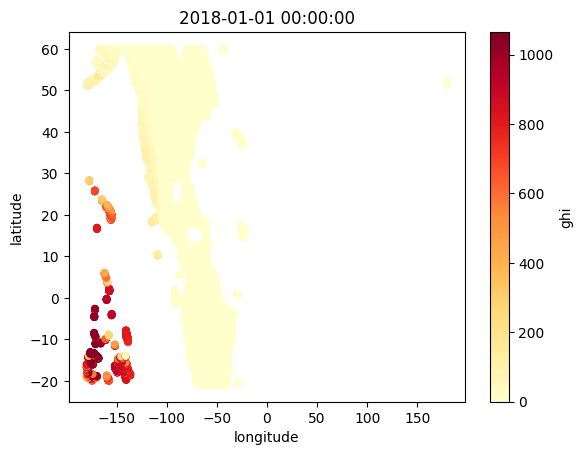

In [104]:
# Plot the ghi for all coordinates
plot_ghi(f, '2018-01-01 00:00:00', coords, data)

In [35]:
# Get the dataset of a given state
state_name = 'California'
california = load_state_data(f, state_name)

In [ ]:
# Plot state heatmaps and save them
state_name = 'California'
california = load_state_data(f, state_name)

date_arr = ['2018-01-01', '2018-06-01']
time_arr = ['14:00:00', '17:00:00', '20:00:00', '23:00:00']
images = []
for i in date_arr:
    for j in time_arr:
        timestamp = i + ' ' + j
        timestep = np.where(time_index == timestamp)[0][0]
        file_name = state_name+'_'+timestamp+'_'+'heatmap.jpg'
        plot_state_ghi(f, timestamp, california, file_name)
        images.append(imageio.imread(file_name))
        
imageio.mimsave('test.gif', images)

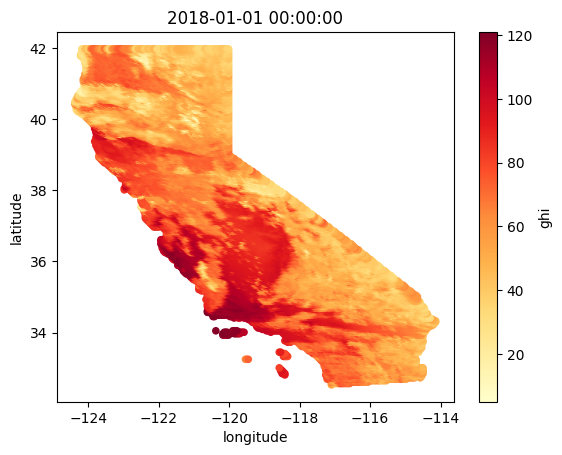

In [69]:
file_name = state_name+'_'+timestamp+'_'+'heatmap.jpg'
plot_state_ghi(f, timestamp, california, file_name)

## Nearest Timeseries for given Lat/Lon

In [11]:
# Plot the ghi for whole year of a given coordinate
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

# coords = f['coordinates'][:]
tree = cKDTree(coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

# NewYorkCity = (40.7128, -74.0059)
# NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1])

# print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
# print("Coordinates of New York City: \t {}".format(NewYorkCity))
# print("Coordinates of nearest point: \t {}".format([NewYorkCity_idx]))
SanDiego = (32.715736, -117.161087)
SanDiego_idx = nearest_site(tree, SanDiego[0], SanDiego[1])

print("Site index for New York City: \t\t {}".format(SanDiego_idx))
print("Coordinates of New York City: \t {}".format(SanDiego))
print("Coordinates of nearest point: \t {}".format([SanDiego_idx]))


Site index for New York City: 		 71886
Coordinates of New York City: 	 (32.715736, -117.161087)
Coordinates of nearest point: 	 [71886]


In [30]:
# Get the entire 2012 timeseries data for a point in NYC
tseries = f['ghi'][::2, SanDiego_idx] / f['ghi'].attrs['psm_scale_factor']

In [31]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

8760

In [36]:
df_ca = california[['longitude', 'latitude']].copy()
df_ca

,longitude,latitude
70276,-117.099998,32.529999
70588,-117.099998,32.570000
70589,-117.059998,32.570000
70590,-117.019997,32.570000
70591,-116.980003,32.570000
...,...,...
172687,-120.180000,41.970001
172688,-120.139999,41.970001
172689,-120.099998,41.970001
172690,-120.059998,41.970001


In [37]:
df_ca.index

Index([ 70276,  70588,  70589,  70590,  70591,  70592,  70593,  70594,  70595,
        70596,
       ...
       172682, 172683, 172684, 172685, 172686, 172687, 172688, 172689, 172690,
       172691],
      dtype='int64', length=26010)

In [71]:
ca_index = np.array(df_ca.index)
ca_index

array([ 70276,  70588,  70589, ..., 172689, 172690, 172691])

In [72]:
tseries_ca = np.sum(f['ghi'][::2, ca_index[::10]] / f['ghi'].attrs['psm_scale_factor'], axis=1)

In [ ]:
sum_of_ghi = [0] * 8760
for i in ca_index:
    sum_of_ghi += f['ghi'][::2, i] / f['ghi'].attrs['psm_scale_factor']

In [ ]:
np.sum(f['ghi'][::2, [70276, 172685]], axis=1)

In [66]:
print(f['ghi'][::2, 70276])
print(f['ghi'][::2, 172685])
np.sum(f['ghi'][::2, [70276, 172685]], axis=1)

[ 51   2   0 ... 110 221 114]
[ 39   0   0 ... 424 328 197]


array([ 90,   2,   0, ..., 534, 549, 311], dtype=uint64)

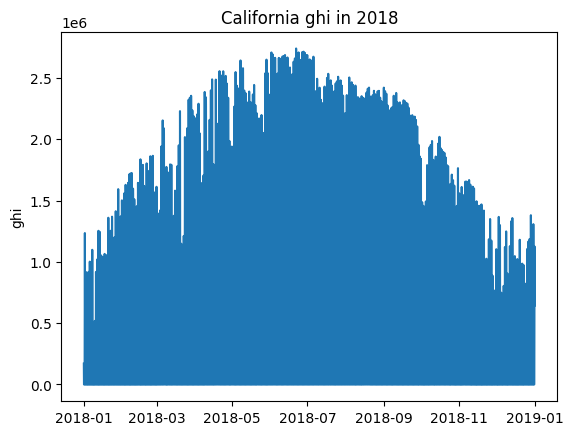

In [74]:
plt.plot(time_index[::2], tseries_ca)
plt.ylabel("ghi")
plt.title("California ghi in 2018")
plt.savefig('California_ghi_in_2018.jpg')

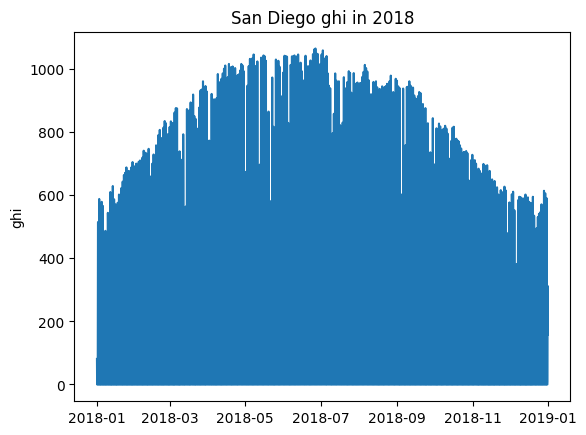

In [33]:
plt.plot(time_index[::2], tseries)
plt.ylabel("ghi")
plt.title("San Diego ghi in 2018")
file_name = 'San_Diego_ghi_in_2018.jpg'
plt.savefig(file_name)

## GHI Statistics

In [15]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,98.032258,6.112903,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,41.677419,163.822581,307.112903,443.306452,518.258065,544.790323,497.774194,381.887097,252.612903
2,203.892857,38.839286,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.892857,93.785714,269.946429,445.892857,587.642857,674.625000,701.017857,646.803571,544.767857,396.964286
3,257.870968,83.096774,2.064516,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,30.354839,145.580645,304.580645,479.145161,648.258065,739.596774,762.790323,694.225806,576.919355,439.838710
4,351.800000,156.466667,15.450000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,96.983333,255.166667,424.150000,638.833333,799.700000,884.583333,896.650000,829.616667,720.266667,553.950000
5,377.580645,196.241935,41.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,98.838710,211.354839,333.741935,506.983871,690.741935,788.483871,810.209677,776.145161,701.725806,569.709677
6,445.683333,252.183333,78.283333,1.433333,0.0,0.0,0.0,0.0,0.0,0.0,...,91.266667,210.133333,406.883333,603.566667,784.566667,892.050000,911.933333,874.066667,804.933333,651.950000
7,441.112903,245.903226,73.080645,1.225806,0.0,0.0,0.0,0.0,0.0,0.0,...,119.774194,265.451613,452.774194,632.548387,769.822581,852.951613,855.951613,825.000000,747.870968,621.000000
8,396.451613,192.758065,34.532258,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,110.838710,242.387097,441.306452,647.241935,818.290323,918.403226,921.064516,860.548387,745.080645,594.629032
9,298.966667,95.400000,2.800000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,66.750000,151.933333,312.650000,502.366667,667.766667,767.583333,784.333333,726.566667,649.200000,495.000000


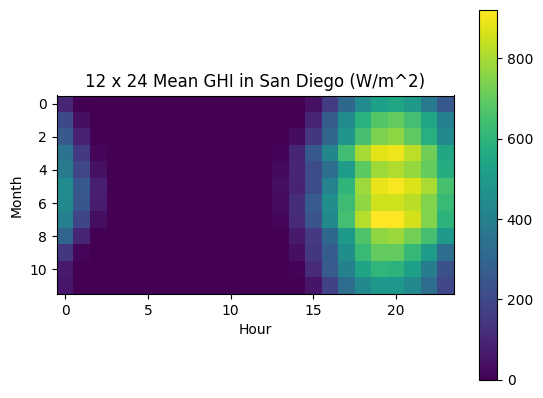

In [20]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI in San Diego (W/m^2)")
plt.colorbar()
file_name = 'Mean_GHI_in_San_Diego.jpg'
plt.savefig(file_name)